In [64]:
import netCDF4 as nc
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt


In [8]:
sys.path

['C:\\Users\\zlukich\\Desktop\\work\\no_palm\\netcdf reader',
 'C:\\Users\\zlukich\\anaconda3\\python310.zip',
 'C:\\Users\\zlukich\\anaconda3\\DLLs',
 'C:\\Users\\zlukich\\anaconda3\\lib',
 'C:\\Users\\zlukich\\anaconda3',
 '',
 'C:\\Users\\zlukich\\AppData\\Roaming\\Python\\Python310\\site-packages',
 'C:\\Users\\zlukich\\anaconda3\\lib\\site-packages',
 'C:\\Users\\zlukich\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\zlukich\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\zlukich\\anaconda3\\lib\\site-packages\\Pythonwin']

In [11]:
ds = nc.Dataset("../data/photoshade_6km10m_lod2_chemistry.nc")

In [36]:
ds["emission_values"]

<class 'netCDF4._netCDF4.Variable'>
float32 emission_values(time, z, y, x, nspecies)
    long_name: emission values
    _Fill_Value: -999.9
    units: g/m2/hour
unlimited dimensions: time
current shape = (48, 1, 672, 672, 5)
filling on, default _FillValue of 9.969209968386869e+36 used

In [42]:
ds["nspecies"][:]

masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999)

In [43]:
ds["emission_values"][0,0,:,:,0].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Save information as CSV file

In [72]:
pd_15hour_3species = pd.DataFrame(ds["emission_values"][15,0,:,:,2].data)

In [84]:
pd_15hour_3species["hour"] = 15

In [85]:
pd_15hour_3species

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,hour
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
1,0.0,0.0,0.0,0.0,4.056503,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
2,0.0,0.0,0.0,0.0,0.000000,4.056503,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
3,0.0,0.0,0.0,0.0,0.000000,0.000000,4.056503,4.056503,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
4,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.056503,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
668,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
669,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15
670,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15


### DF concatenation

In [89]:
result_3species = pd.DataFrame()
for i in range(48):
    pd_ihour_3species = pd.DataFrame(ds["emission_values"][i,0,:,:,2].data)
    pd_ihour_3species["hour"] = i
    result_3species= pd.concat([result_3species,pd_ihour_3species])

In [90]:
result_3species

,0,1,2,3,4,5,6,7,8,9,...,663,664,665,666,667,668,669,670,671,hour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47
670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47


# Plot pollution distribution

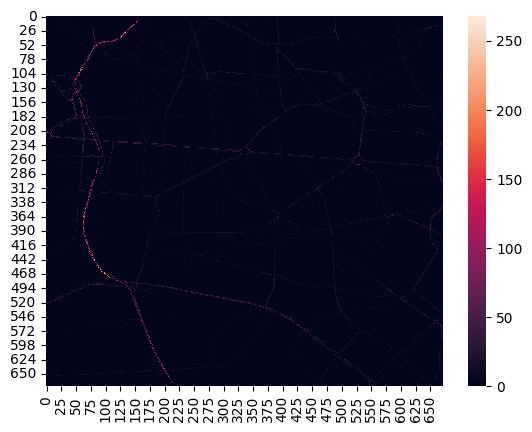

In [83]:
ax = sns.heatmap(ds["emission_values"][15,0,:,:,2].data)
plt.show()

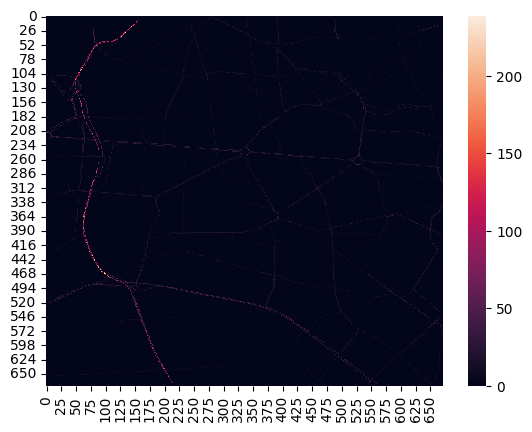

In [82]:
ax = sns.heatmap(ds["emission_values"][30,0,:,:,2].data)
plt.show()